In [9]:
%%capture
!pip install fastai==2.0.0
!pip install fastcore==1.0.0

## Setting workspace

In [13]:
import boto3
import os
import numpy as np
from pathlib import Path
from argparse import Namespace
from fastai2.vision.all import *

args = Namespace(
    root = "/".join(os.getcwd().split("/")[:-1]),
    bucket_name = "sagemaker-us-west-2-430127992102",
    key = "ClassificationModel",
    image_dir = "fastai_data",
    data_dir = "dataset",
    tar_file_name = "dataset.tar.gz",
    model_dir = "model",
    tar_model_name = "model.tar.gz"
)
s3 = boto3.resource('s3')

## Download data from S3

In [14]:
s3.Bucket(args.bucket_name).download_file(Key = os.path.join(args.key, args.data_dir, args.tar_file_name),
                                         Filename = os.path.join(args.root, args.data_dir, args.tar_file_name))
tarfile.open(os.path.join(args.root, args.data_dir, args.tar_file_name), "r:gz").extractall(
    os.path.join(args.root, args.data_dir)
)

In [ ]:
os.remove(os.path.join(args.root, args.data_dir, args.tar_file_name))

In [72]:
model_path = os.path.join(args.root, args.model_dir)
data_path = Path(os.path.join(args.root, args.data_dir))
labels = os.listdir(data_path)

In [15]:
import fastai
import fastcore
fastai.__version__, fastcore.__version__

('2.0.0', '0.1.39')

## Loading data

In [54]:
data = ImageDataLoaders.from_folder(data_path, valid_pct=0.2, bs=32, item_tfms=Resize(224), 
                    batch_tfms=[*aug_transforms(),Normalize.from_stats(*imagenet_stats)], num_workers=3)

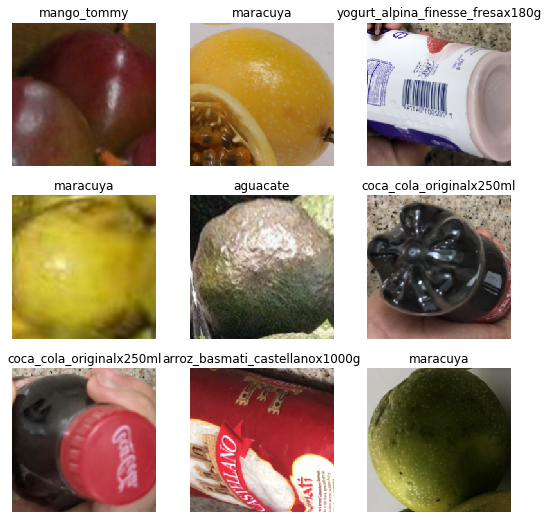

In [56]:
data.show_batch()

## Training pretrained model

In [60]:
learn = cnn_learner(data, resnet34, metrics=[error_rate,accuracy])

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0030199517495930195)

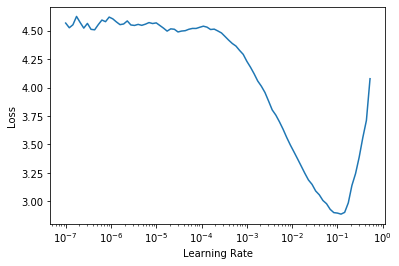

In [61]:
learn.lr_find()

In [62]:
learn.fit_one_cycle(3,lr=6e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.329937,0.392673,0.128332,0.871668,02:10
1,0.599325,0.267307,0.099704,0.900296,02:08
2,0.399772,0.224018,0.081935,0.918065,02:10


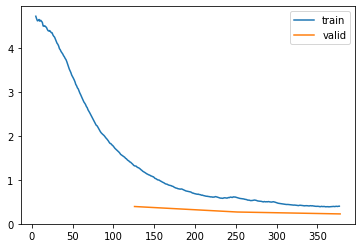

In [63]:
learn.recorder.plot_loss()

In [64]:
learn.save(os.path.join(model_path,'stage-1'))

In [90]:
learn.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=1.3182567499825382e-06)

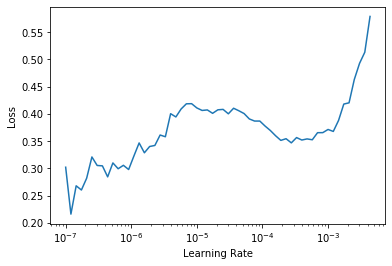

In [91]:
learn.lr_find()

In [92]:
learn.fit_one_cycle(10,lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.540667,0.784894,0.195459,0.804541,02:14
1,0.835209,0.907412,0.255676,0.744324,02:13
2,0.711716,0.699136,0.199408,0.800592,02:12
3,0.652723,0.676272,0.217177,0.782823,02:13
4,0.535761,0.560638,0.169793,0.830207,02:14
5,0.462294,0.320766,0.122409,0.877591,02:12
6,0.358266,0.230104,0.076999,0.923001,02:13
7,0.234502,0.158761,0.060217,0.939783,02:13
8,0.181597,0.147556,0.057256,0.942744,02:12
9,0.159508,0.139820,0.050346,0.949655,02:13


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f443a5e30b8>>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f443a5e30b8>>
Traceback (most recent call last):
  File "/home/ec2-user

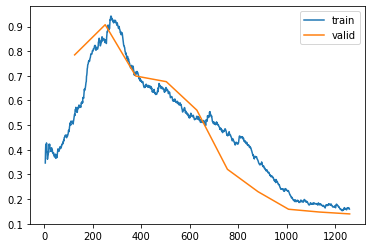

In [93]:
learn.recorder.plot_loss()

In [28]:
learn.load(os.path.join(model_path, 'stage-1'))

In [94]:
learn.save(os.path.join(model_path, 'stage-2'))

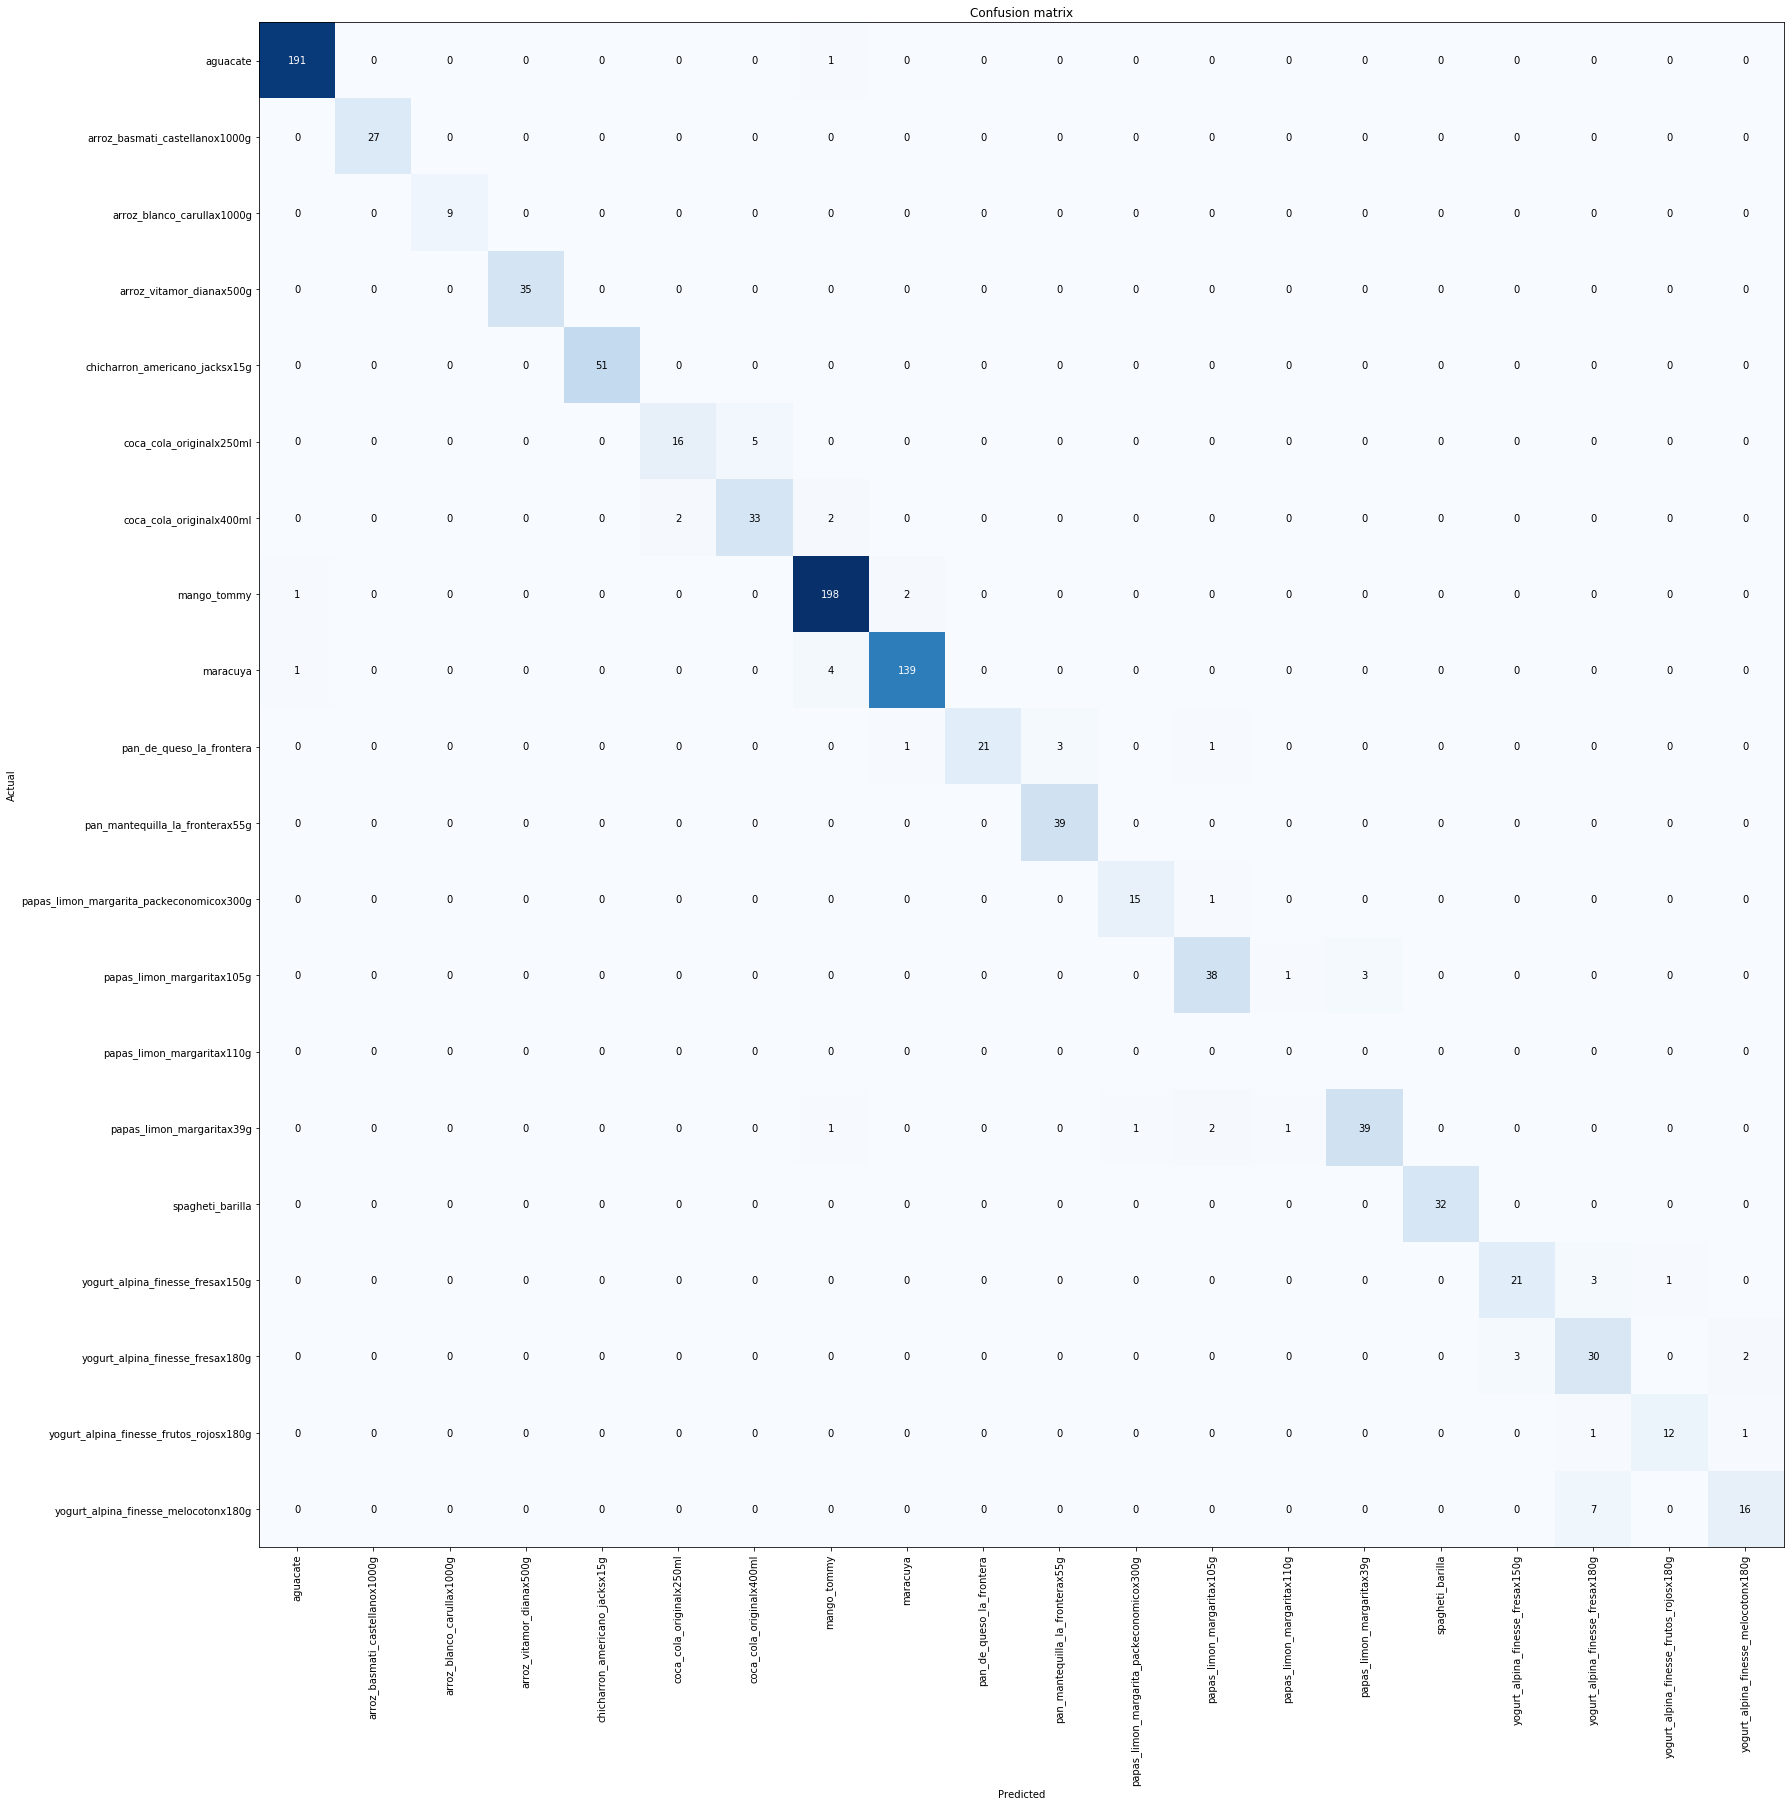

In [95]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(30,25))

In [82]:
import json
from PIL import Image
!curl "https://jumbocolombiafood.vteximg.com.br/arquivos/ids/3496861-750-750/7702001041701.jpg?v=637230819964000000" --output test.jpg
#img = Image.open('test.jpg')
#img.show()
pred_class,pred_idx,outputs = learn.predict('test.jpg')
print(json.dumps({class_name: prob.item()} for class_name, prob in zip(labels, outputs)) )
#print(json.dumps({"probabilities": {class_name: prob.item()}}))
                         #for class_name, prob in zip(data.classes, outputs)}}, indent=3))
!rm test.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54180  100 54180    0     0   539k      0 --:--:-- --:--:-- --:--:--  539k


TypeError: Object of type 'generator' is not JSON serializable

In [49]:
data.labels

AttributeError: labels

In [40]:
!curl "https://jumbocolombiafood.vteximg.com.br/arquivos/ids/3496861-750-750/7702001041701.jpg?v=637230819964000000" --output test.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54180  100 54180    0     0  1290k      0 --:--:-- --:--:-- --:--:-- 1290k


In [41]:
!ls

model.ipynb  test.jpg
